# AOS_benchmark_phosim 

Run the same code for `{comCam-single CCD-15 sec exposure}x{high}x{quickbackground / backgroundmode0}`on  UW hyak https://wiki.cac.washington.edu/display/hyakusers/Mox_scheduler,  NCSA slurm ,  epyc . 
    
    
    Note: the resources at NCSA - "all of the various clusters have identical hardware, software, etc. Here is a current summary of the node count in each:

    HTCondor DAC - 15 nodes - submit from lsst-devl* nodes

    HTCondor Production - 10 nodes - limited access to submit from lsst-condorprod-sub01

    Slurm - 16 nodes - submit from lsst-devl* nodes


## Prepare catalogs

For high field, just use `/project/scichris/aos/ps1_phosim/stars_comCam_PS1_high_focal.inst`, 
but for low-lat field, the catalog is 34MB, and we don't need the entire catalog to just run on one CCD.

So I open the catalog, plot the sources, and clip the edges : 
    
    

In [2]:
import numpy as np 
import pandas as pd
# read in the input instance catalog 
cat = np.genfromtxt('/project/scichris/aos/ps1_phosim/stars_comCam_PS1_low_focal.inst',
                        skip_header=16)

cat_df = pd.DataFrame(cat[:, 1:5], columns=['id', 'ra', 'dec', 'g'])


In [ ]:
the boresight is 

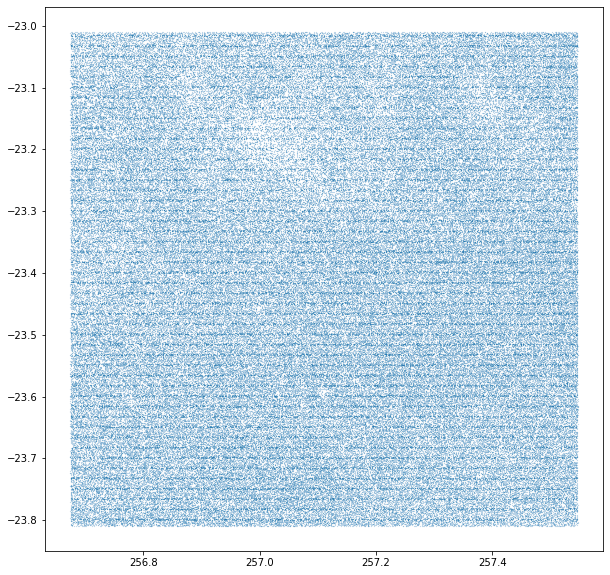

In [11]:
import matplotlib.pyplot as plt 
%matplotlib inline

fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.scatter(cat_df['ra'], cat_df['dec'], s=0.01)

### For NCSA slurm: 


    ssh scichris@lsst-login01.ncsa.illinois.edu 
    ssh lsst-devl03 
    
    screen -S benchmark
    source "/software/lsstsw/stack3/loadLSST.bash"
    setup lsst_distrib
    setup -k -r /project/scichris/aos/phosim_utils/
    
    (later screen -x benchmark ) 

In [8]:
# Use the `/project/scichris/aos/ps1_phosim/stars_comCam_PS1_high_focal.inst`  catalog, and run phosim with 
import os 
import subprocess 

# define paths
phosim_path = "/project/scichris/aos/phosim_syseng4/phosim.py"
root_dir = "/project/scichris/aos/ps1_phosim/"
cmd = 'noBkgnd.cmd'
phosim_p = 24
phosim_t = 1
instrument='comCam'
field='high'
position='focal'
sensor='R22_S11' # pick just one CCD 

print("\n", instrument, field, position)
# define instance catalog and physics command file
inst_file = os.path.join(
    root_dir, f"stars_{instrument}_PS1_{field}_{position}.inst"
)
cmd_file = os.path.join(root_dir, cmd)

if instrument == "lsstCam":
    instr = "lsst"
elif instrument == "comCam":
    instr = "comcam"

# ensure the output path exists
work_dir = os.path.join(root_dir, 'benchmark','noBkgnd')
out_dir = os.path.join(work_dir, "raw")
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
log_file = os.path.join(work_dir, "starPhoSim.log")

# run phosim
command = f"python {phosim_path} {inst_file} -i {instr} -e 1 \
-c {cmd_file} -p {phosim_p} -s {sensor} -o {out_dir} > {log_file} 2>&1"
phosim_command = command

print(f"\nRunning via subprocess: \n {command}\n")
t0 = time.time()
if subprocess.call(command, shell=True) != 0:
    raise RuntimeError("Error running: %s" % command)
ttl_time = time.time() - t0
print(f"Running phosim took {ttl_time:.3f} seconds")

# repackage the output
repackaged_dir = os.path.join(work_dir, "repackaged")
command = f"phosim_repackager.py {out_dir} \
--out_dir {repackaged_dir} --inst {instr}"
 print(f"\nRunning via subprocess: \n {command}\n")
repackager_command = command
if subprocess.call(command, shell=True) != 0:
    raise RuntimeError("Error running: %s" % command)





 comCam high focal

Run phosim with  
 python /project/scichris/aos/phosim_syseng4/phosim.py /project/scichris/aos/ps1_phosim/stars_comCam_PS1_high_focal.inst -i comcam -e 1 -c /project/scichris/aos/ps1_phosim/noBkgnd.cmd -p 24 -o /project/scichris/aos/ps1_phosim/benchmark/noBkgnd/raw > /project/scichris/aos/ps1_phosim/benchmark/noBkgnd/starPhoSim.log 2>&1


Run repackager with 
 phosim_repackager.py /project/scichris/aos/ps1_phosim/benchmark/noBkgnd/raw --out_dir /project/scichris/aos/ps1_phosim/benchmark/noBkgnd/repackaged --inst comcam



easiest way to test how long it took - once it's finished, check the timestamps of each amp image ... in-between is how long it took.  But also would be good to record the start time , end time and print to a file ... 

So perhaps put all into a python script `benchmark.py` https://developer.lsst.io/services/batch.html#rubin-batch-systems-overview 

I made slurm script requesting 1 core and 24 tasks,  `runSlurmBenchmark.py`  :

    #!/bin/bash -l
    #SBATCH --partition normal
    #SBATCH --nodes 1
    #SBATCH --ntasks 24
    #SBATCH -t 1000:00:00
    #SBATCH --job-name bench

    echo "starting at `date` on `hostname`"

    pwd

    python /project/scichris/aos/ps1_phosim/benchmark.py --dir_name slurmNoBkgnd -p 24 --cmd noBkgnd.cmd 

    echo "ended at `date` on `hostname`"

I run it with : 

    sbatch runSlurmBenchmark.py
    
I also run the `quickbackground` on slurm where I changed the above line to 

    python /project/scichris/aos/ps1_phosim/benchmark.py --dir_name slurmQckBkgnd -p 24 --cmd qckBkgnd.cmd
    
with  
    
    sbatch runSlurmBenchmark2.sl 
    

with 
    sinfo -Nl

I find out how much memory there is in each node, and there is 128G, so  I first thought to select 


    #SBATCH --mem=118G
    
But  I get my job held because `MaxMemPerLimit`.

So from  
    
    scontrol show partition normal
    
I find that `MaxMemPerNode=115712` , so I set to `115G` : 

    $SBATCH --mem=115G 
    
But I was still getting the pesky `MaxMemPerNode`... Finaly `110G` seems to do the trick : 

jobs `51471` and `51472` are orderly awaiting their turn. 



#### Investigate the resulting postISR images:

In [2]:
from lsst.daf import butler as dafButler
import lsst.afw.cameraGeom.utils as cameraGeomUtils
import lsst.afw.display as afwDisplay
import matplotlib.pyplot as plt
from matplotlib import rcParams 
from astropy.io import fits
from astropy.visualization import ZScaleInterval

import numpy as np 
import os 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

def plot_raw_postISR(repo_dir,instrument,detector='R22_S11'):
    
    butler = dafButler.Butler(repo_dir, collections=[f'{instrument}/raw/all',
                                                     f'{instrument}/calib','run1',
                                                     f'{instrument}/calib/unbounded'],
                             )


    # this is just to get the exposure  number
    # so that we don't have  to guess...
    dataId0 = dict(instrument=instrument)
    dataset = next(iter(
                        butler.registry.queryDatasets(
                            datasetType='postISRCCD', 
                            collections=['run1'],
                            dataId=dataId0  )
                        )
                   )
    exp_num = dataset.dataId["exposure"]
    print(exp_num)
    zscale = ZScaleInterval()
     
    # initialize the figure 
    fig,ax = plt.subplots(1,2,figsize=(18,9))

    # get the raw exposure 
    exposure = butler.get('raw', detector=detector, instrument=instrument,
              exposure=exp_num,)

    data = exposure.image.array
    vmin, vmax = zscale.get_limits(data)
    ax[0].imshow(exposure.image.array, vmin=vmin,vmax=vmax,cmap='Greys',
                origin='lower')

    ax[0].set_title("raw")
    ax[0].set_xlabel('x [px]')
    ax[0].set_ylabel('y [px]')

    # get the postISR exposure 
    exposure = butler.get('postISRCCD', detector=detector, instrument=instrument,
              exposure=exp_num,collections=['run1'])

    data = exposure.image.array
    vmin, vmax = zscale.get_limits(data)
    ax[1].imshow(exposure.image.array, vmin=vmin,vmax=vmax,cmap='Greys',
                origin='lower')

    ax[1].set_title("postISR")
    ax[1].set_xlabel('x [px]')
    ax[1].set_ylabel('y [px]')
    fig.suptitle(f"{instrument} {exposure.getDetector().getName()}",
                fontsize=18)


4021123106002


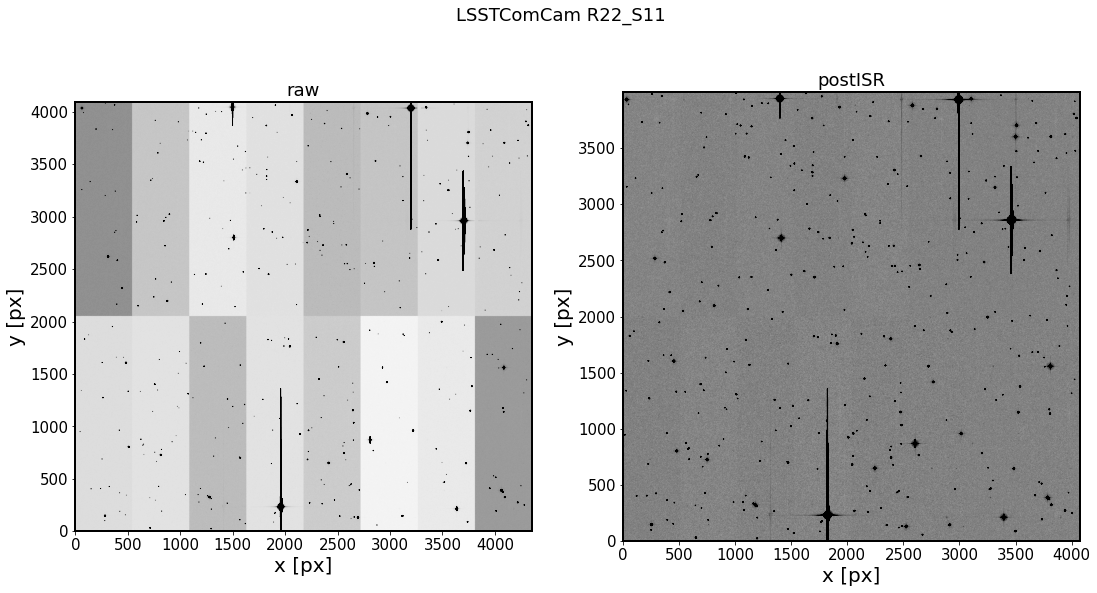

In [3]:
# High latitude field , no background 
instrument = 'LSSTComCam'
repo_dir = '/project/scichris/aos/ps1_phosim/benchmark/slurmNoBkgnd/DATA/'
plot_raw_postISR(repo_dir,instrument)   

4021123106002


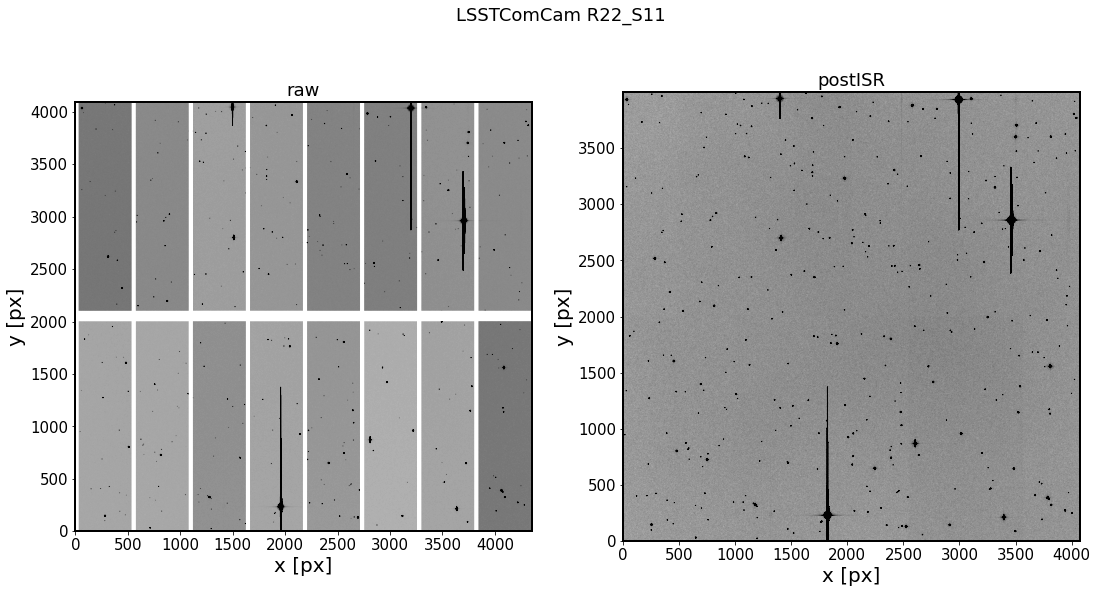

In [11]:
# High latitude,  qck background 
instrument = 'LSSTComCam'
repo_dir = '/project/scichris/aos/ps1_phosim/benchmark/slurmQckBkgnd2/DATA/'
plot_raw_postISR(repo_dir,instrument)   

Medium latitude:  

4021123106002


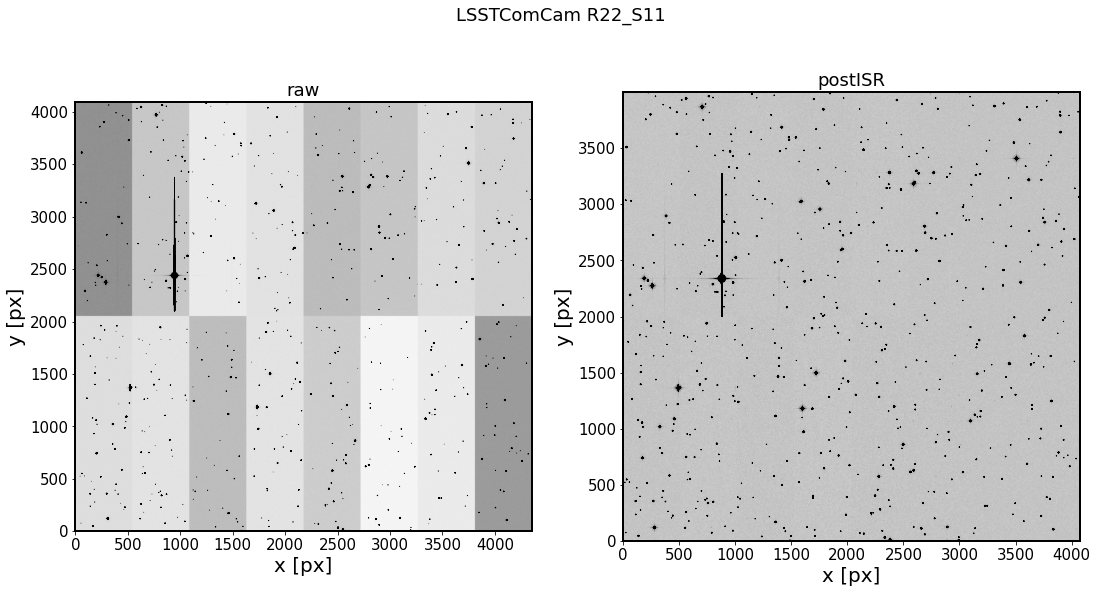

In [12]:
# Med latitude field , no background 
instrument = 'LSSTComCam'
repo_dir = '/project/scichris/aos/ps1_phosim/benchmark/slurmNoBkgndMed1/DATA/'
plot_raw_postISR(repo_dir,instrument)   

4021123106002


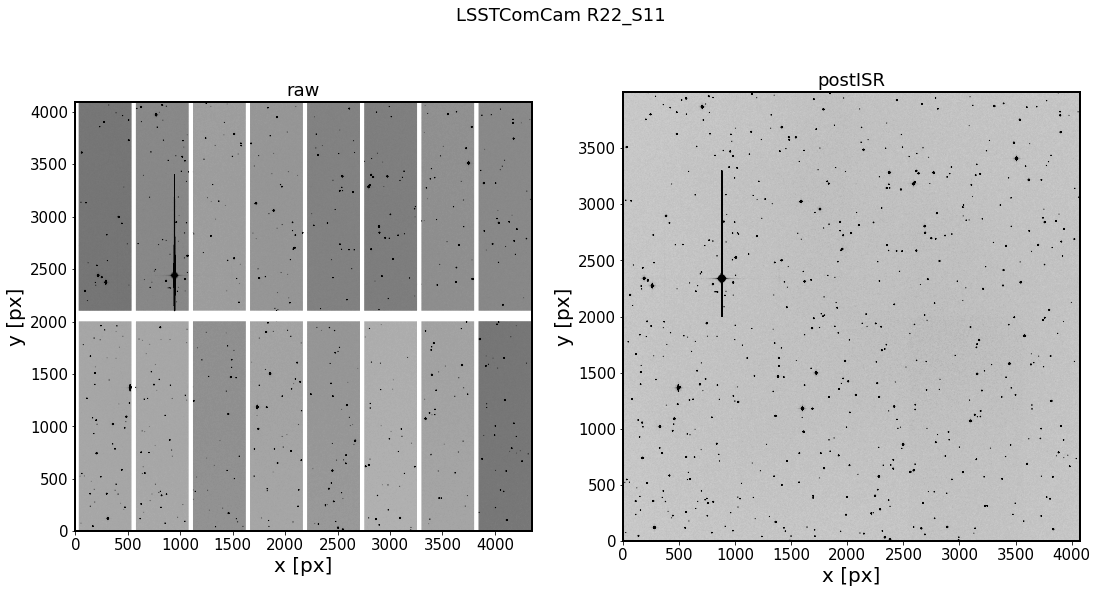

In [13]:
# Med latitude field , qck background 
instrument = 'LSSTComCam'
repo_dir = '/project/scichris/aos/ps1_phosim/benchmark/slurmQckBkgndMed1/DATA/'
plot_raw_postISR(repo_dir,instrument)   

Low latitude : 

4021123106002


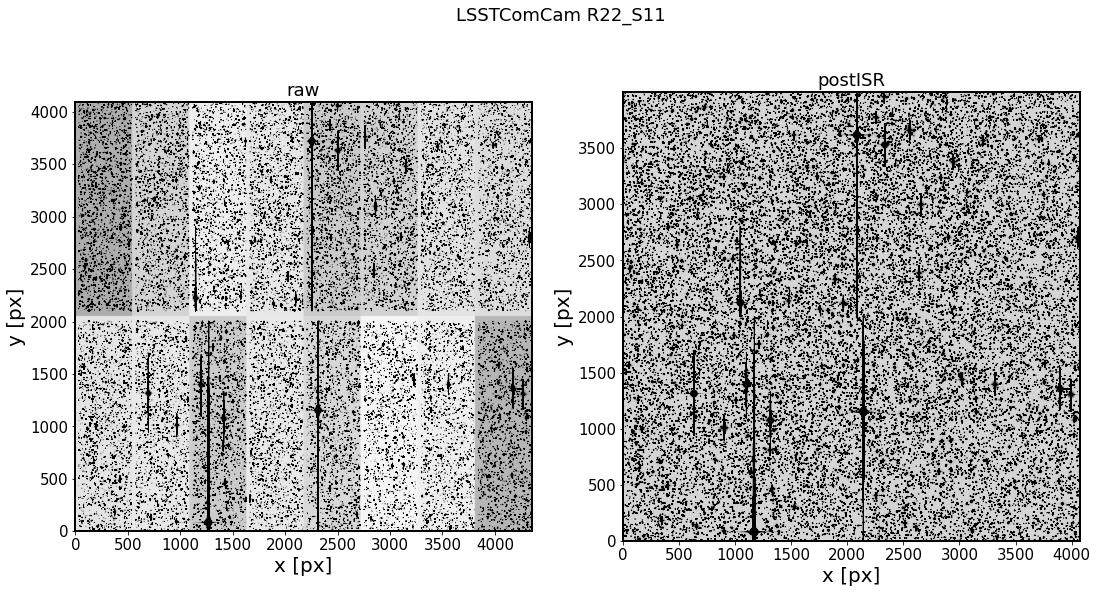

In [14]:
# Low latitude field , no background 
instrument = 'LSSTComCam'
repo_dir = '/project/scichris/aos/ps1_phosim/benchmark/slurmNoBkgndLow1/DATA/'
plot_raw_postISR(repo_dir,instrument)   

4021123106002


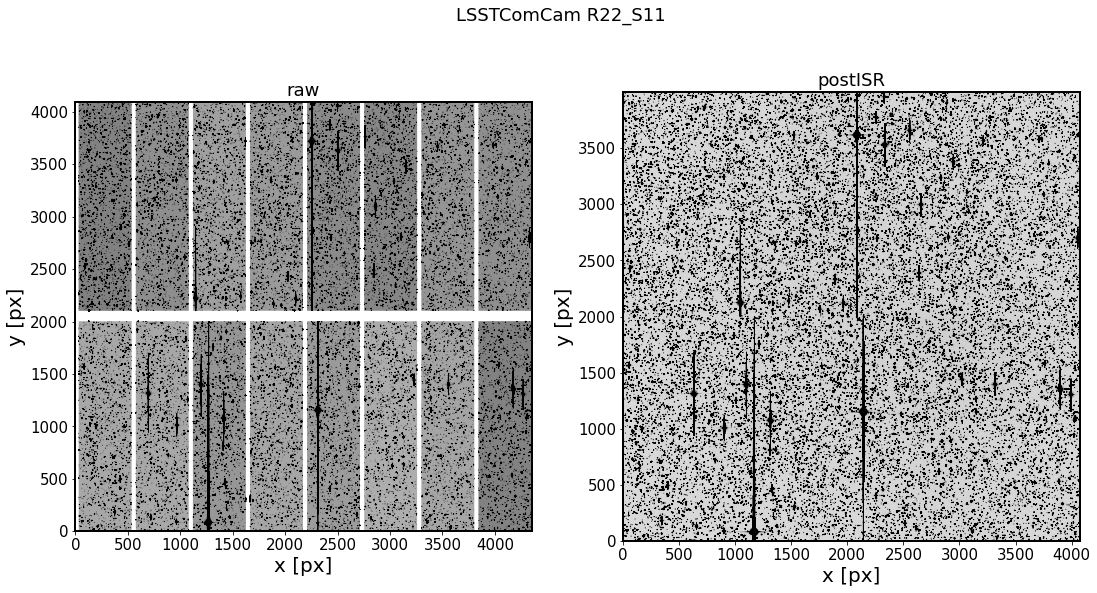

In [15]:
# Low latitude field , qck background 
instrument = 'LSSTComCam'
repo_dir = '/project/scichris/aos/ps1_phosim/benchmark/slurmQckBkgndLow1/DATA/'
plot_raw_postISR(repo_dir,instrument)   

Baade's window:

4021123106002


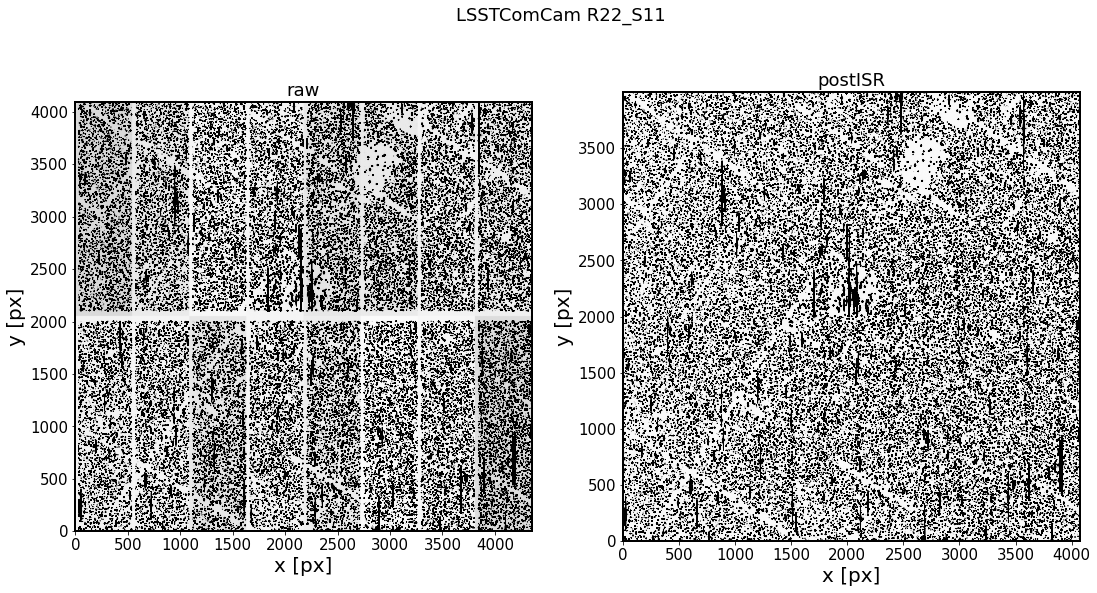

In [16]:
# Baade's window  field , no background 
instrument = 'LSSTComCam'
repo_dir = '/project/scichris/aos/ps1_phosim/benchmark/slurmNoBkgndBaade1/DATA/'
plot_raw_postISR(repo_dir,instrument)   

4021123106002


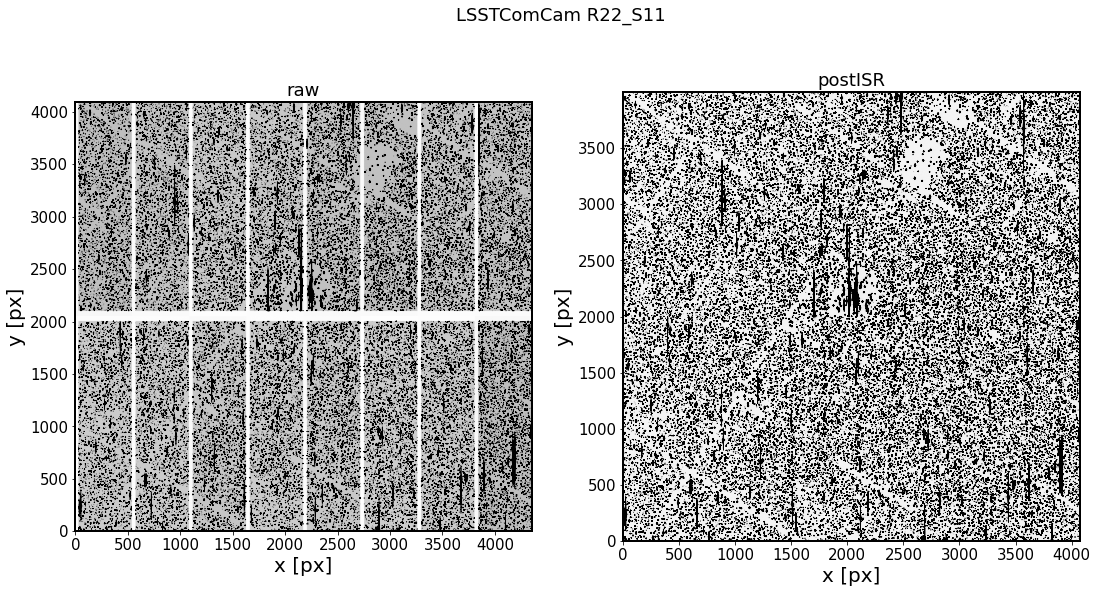

In [17]:
# Baade's window  field , qck background 
instrument = 'LSSTComCam'
repo_dir = '/project/scichris/aos/ps1_phosim/benchmark/slurmQckBkgndBaade1/DATA/'
plot_raw_postISR(repo_dir,instrument)   

In [3]:
import numpy as np 
a = [25303, 25314, 25381]
mean = np.mean(a)
print(mean, mean/3600. )


25332.666666666668 7.036851851851853


In [5]:
np.mean([7.04,9.23])

8.135

In [9]:
9*2*(0.85+0.98+0.67+0.74+1.91+2.38+7.8+8.14)/24

17.6025

In [43]:
0.9*74

66.60000000000001

# UW Hyak 

Copy the benchmark script, the `.inst` and `cmd` files over to epyc : 
    
    
    ssh lsst-login01
    
    # copy from where I develop it on LSP to /project 
    cd /project/scichris/aos/ps1_phosim/
    cp /home/scichris/notebooks/benchmark.py .
    
    
    # put the cmd, inst, and benchmark.py to a single package:
    cp benchmark.py package
    cp noBkgnd.cmd package
    cp qckBkgnd.cmd package
    cp stars_comCam_PS1_high_focal.inst package
    
    # compress with tar into a single archive 
    tar -czvf package.tar.gz package/
    
    # copy from NCSA to UW epyc 
    scp package.tar.gz suberlak@epyc.astro.washington.edu:/epyc/users/suberlak/Commissioning/aos/
    
    # copy from NCSA to UW hyak 
    scp package.tar.gz suberlak@mox.hyak.uw.edu:/gscratch/astro/suberlak/aos/
    
    # Log onto hyak submission node:
    ssh suberlak@mox.hyak.uw.edu
    
    # unpack the package 
    cd /gscratch/astro/suberlak/aos/
    tar -xzf package.tar.gz 



    
Note - now it's easier to just **clone the github repo**  :


    # Log onto hyak submission node:
    ssh suberlak@mox.hyak.uw.edu
    cd /gscratch/astro/suberlak/aos/
    git clone https://github.com/suberlak/AOS.git
    
     
    # make a submit script 
    
   

Following the instructions from https://wiki.cac.washington.edu/display/hyakusers/Mox_scheduler : 
        
    ssh suberlak@mox.hyak.uw.edu 
    sinfo -p astro  # show node allocation for "astro" partition 
    scontrol show part astro # show resources for "astro" partition 
     
    sinfo -Nl -p astro # show the node resources for "astro" partition 
    # other options for sinfo - https://slurm.schedmd.com/sinfo.html 
    
    sinfo summarize -p astro
    sinfo -O all -p astro
    
    
    # print info about one of the astro nodes:
     scontrol show node n2240
    
I find out that each `astro` node has 28 cores, thus selecting 24 is fine, and it makes the best comp for NCSA slurm.

The memory is 515 GB on some, and 256GB on others.  



Fortunately, Bryce already installed phosim on  hyak at `/gscratch/astro/brycek/ts_repos/phosim_syseng4` , and he setups the aos pipeline with  `/gscratch/astro/brycek/lsst/aos_scripts/setup_aos.bash` 

So I make the slurm-submit script :
    
    #!/bin/bash -l
    #SBATCH --account astro 
    #SBATCH --partition astro
    #SBATCH --nodes 1
    #SBATCH --ntasks-per-node 24
    #SBATCH -t 1000:00:00
    #SBATCH --job-name bench
    #SBATCH --mem=500G  # 256GB is the smallest astro node , so if that's the only available select 246G here  

    ##turn on e-mail notification
    #SBATCH --mail-type=ALL
    #SBATCH --mail-user=suberlak@uw.edu

    ## export all your environment variables to the batch job session
    #SBATCH --export=all


    ## may not need that one, since everywhere I provide abspath ...
    ## specify working directory for the  job ... 

    #SBATCH --chdir=/gscratch/astro/suberlak/aos/      
    echo "starting at `date` on `hostname`"

    pwd

    python /gscratch/astro/suberlak/aos/package/benchmark.py --dir_name hyakNoBkgnd -p 24 --cmd noBkgnd.cmd  --phosim_path /gscratch/astro/brycek/ts_repos/phosim_syseng4/phosim.py --root_dir /gscratch/astro/suberlak/aos/benchmark/

    echo "ended at `date` on `hostname`"
    
    
**Make sure that lsst stack is available for python**

    #source /gscratch/astro/brycek/lsst_stack_w_2020_38/loadLSST.bash
    
    
    setup lsst_distrib
    setup -k -r /gscratch/astro/suberlak/aos/phosim_utils/
    
    
    # I open the screen with 
    screen -S benchmark 
    
    # or simply source : 
##########
   ##### #####
   
    source /gscratch/astro/suberlak/aos/setup_aos.sh 
    
  ##########  #####
  
I submitted the job with 

    sbatch runSlurm.sl 

But then when I checked with `squeue -u suberlak` it was help up due to `(ReqNodeNotAvail, Reserved for maintenance) `, which is because it had so much time allocated by `#SBATCH -t ` that it would not end before the scheduled maintenance https://ubccr.freshdesk.com/support/solutions/articles/5000681170-what-does-request-node-not-available-mean-  

So I adjusted `#SBATCH -t` to `10:00:00` hours, since it would be done before that 





    python /gscratch/astro/brycek/ts_repos/phosim_syseng4/phosim.py /gscratch/astro/suberlak/aos/benchmark/stars_comCam_PS1_high_focal.inst -i comcam -e 1 -c /gscratch/astro/suberlak/aos/benchmark/noBkgnd.cmd -p 24 -s R22_S11 -o /gscratch/astro/suberlak/aos/benchmark/benchmark/hyakNoBkgnd/raw > /gscratch/astro/suberlak/aos/benchmark/benchmark/hyakNoBkgnd/starPhoSim.log 2>&1
    
    
    phosim_repackager.py /gscratch/astro/suberlak/aos/benchmark/benchmark/hyakNoBkgnd/raw     --out_dir /gscratch/astro/suberlak/aos/benchmark/benchmark/hyakNoBkgnd/repackaged --inst comcam
    
    
    phosim_repackager.py /gscratch/astro/suberlak/aos/benchmark/benchmark/hyakQckBkgnd/raw     --out_dir /gscratch/astro/suberlak/aos/benchmark/benchmark/hyakQckBkgnd/repackaged --inst comcam

can't repackage it, but this is probably because I would have to install the entire stack from the scratch at hyak to 
make sure that scons is using most recent version ... 

Install most recent stack on hyak : 

I follow the instructions from https://pipelines.lsst.io/install/newinstall.html ,  to install the latest weekly `w_2021_19` ( I see which newinstall.sh tags are available at https://github.com/lsst/lsst/tags )  - https://pipelines.lsst.io/install/newinstall.html#newinstall-other-tags 


Note: I needed to log into  a `build` node, and requested `50G` memory so that we don't run out ... 

    cd /gscratch/astro/suberlak/
    mkdir -p lsst_stack
    cd lsst_stack 
    
    curl -OL https://raw.githubusercontent.com/lsst/lsst/master/scripts/newinstall.sh
    bash newinstall.sh -ct
    
    source loadLSST.bash 
    
    eups distrib install -t w_2021_19 lsst_distrib

    setup lsst_distrib
    


Added the benchmarking code together with inst and cmd files needed to the AOS git repo for now

https://github.com/suberlak/AOS/blob/main/benchmark/benchmark.py

Next on hyak : 
    
    * install the stack (most recent weekly) on hyak 
    * run scons in phosim_repackager
    

# Epyc


    ssh epyc
    
    source /astro/store/epyc/projects/lsst_comm/stack_w_2021_14/loadLSST.bash
    setup lsst_distrib 
    
    
    setup -k -r /epyc/users/suberlak/Commissioning/aos/ts_wep/
    setup -k -r /epyc/users/suberlak/Commissioning/aos/ts_ofc/
    setup -k -r /epyc/users/suberlak/Commissioning/aos/ts_phosim/
    setup -k -r /epyc/users/suberlak/Commissioning/aos/phosim_utils/
    
    # this is a version before we fixed ROTANG, but it doesn't matter here ...
    setup -k -r /astro/store/epyc/projects/lsst_comm/phosim_utils/
    
    # clone the repo 
    cd /epyc/users/suberlak/Commissioning/aos/
    git clone https://github.com/suberlak/AOS.git
     
    # find how many cpus and memory there is on epyc : 
    lscpu 
    # I think 96 cpus ... so -p 24 should be quick 
    
    # run the **benchmark** script 
    
    python benchmark.py --dir_name epycNoBkgnd -p 24 --cmd noBkgnd.cmd  --phosim_path /astro/store/epyc/projects/lsst_comm/phosim_syseng4/phosim.py --root_dir /epyc/users/suberlak/Commissioning/aos/AOS/benchmark/
    
    
    python benchmark.py --dir_name epycQckBkgnd -p 24 --cmd qckBkgnd.cmd  --phosim_path /astro/store/epyc/projects/lsst_comm/phosim_syseng4/phosim.py --root_dir /epyc/users/suberlak/Commissioning/aos/AOS/benchmark/